In [2]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [3]:
N_wn = 20
lbound_wn = 0
ubound_wn = 10
quad_points = np.linspace(np.exp(-ubound_wn), np.exp(-lbound_wn), N_wn)

# Two branches

In [3]:
two_branches1 = bempp.api.import_grid('2branches.msh')
vert_two_branches1 = two_branches1.vertices
elt_two_branches1 = two_branches1.elements

space_two_branches1 = bempp.api.function_space(two_branches1,'P',1)

In [ ]:
for dist in np.linspace(0.5, 3, 11):
    vert_two_branches2 = np.zeros((vert_two_branches1.shape[0], vert_two_branches1.shape[1]))
    for i in range(vert_two_branches1.shape[0]):
        for j in range(vert_two_branches1.shape[1]):
            if i != 1:
                vert_two_branches2[i,j] = vert_two_branches1[i,j]
            else:
                vert_two_branches2[i,j] = vert_two_branches1[i,j] + 2*max(vert_two_branches1[1,:]) + dist
                
    elt_two_branches2 = elt_two_branches1
    two_branches2 = bempp.api.Grid(vert_two_branches2, elt_two_branches2)
    space_two_branches2 = bempp.api.function_space(two_branches2,'P',1)

    
    results = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)

        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches1, space_two_branches1, space_two_branches1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches2 , space_two_branches1, space_two_branches1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches1, space_two_branches2 , space_two_branches2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_two_branches2 , space_two_branches2 , space_two_branches2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                              [mat21_zero, mat22_inv]])  

        combined_inverse_free = inv_free_mat2.dot(mat)
        sign, logdet = slogdet(combined_inverse_free)

        results.append(logdet)
        print(logdet)
    print(dist, np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))  

In [ ]:
2 branches
0.5 0.04085052855269765
0.75 0.014978690779077031
1.0 0.007402680261714687
1.25 0.004242268339214112
1.5 0.0026721015047616644
1.75 0.001797020212374327
2.0 0.0012682458744091869
2.25 0.0009289907662187502
2.5 0.0007010072761762055
2.75 0.0005420229588769765
3.0 0.00042773847356012535

In [36]:
two_branches = [0.04085052855269765, 0.014978690779077031, 0.007402680261714687, 0.004242268339214112, 0.0026721015047616644, 0.001797020212374327, 
                0.0012682458744091869, 0.0009289907662187502, 0.0007010072761762055, 0.0005420229588769765, 0.00042773847356012535]
three_branches = [0.05963262978855249, 0.02181883477176215, 0.010802686619067019, 0.006198707256069255, 0.0039051476338978174, 0.0026243843321186854, 
                  0.0018497918517159054, 0.001352850845595652, 0.00101913974799332, 0.0007866885560877382, 0.0006198191163896852]
four_branches = [0.07813691972356827, 0.02850863564039889, 0.014122377819018036, 0.008113370531435439, 0.005117545790098161, 0.0034425746570701356, 
                 0.002428310041721545, 0.001776896805070582, 0.0013390612412449573, 0.0010338656066821886, 0.000814657238810144]
five_branches = [0.02131282045134417, 0.010127546198355073, 0.005834472935947072, 0.0037299909166832548, 0.002553434850179482, 0.001835475004264177,
                0.001368944040639024, 0.0010510175567344175, 0.000826091187773967, 0.0006620563764372004, 0.0005393811019119488]
six_branches = [0.011229000990026463, 0.0050157620251957465, 0.0029655259066944163, 0.001985380294599532, 0.0014274574467458873, 
                0.0010748624576977267, 0.0008362938487262815, 0.0006669597798991079, 0.0005424093555683427, 0.00044822263496567094, 0.0003753868807092592]

In [37]:
four_branches_round = [0.07814, 0.02851, 0.01412, 0.008113, 0.005118, 0.003443, 0.002428, 0.001777, 0.001339, 0.001034, 0.0008147]
six_branches_round = [0.01123, 0.005016, 0.002966, 0.001985, 0.001427, 0.001075, 0.0008363, 0.0006670, 0.0005424, 0.0004482, 0.0003754]

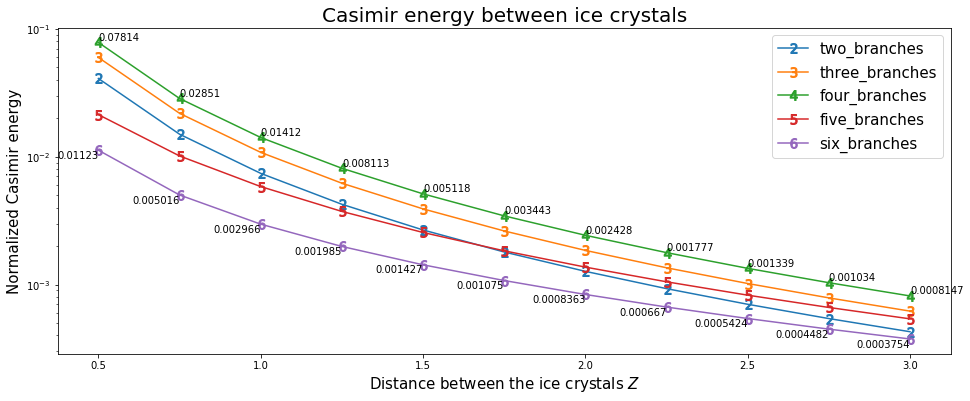

In [39]:
plt.figure(figsize = [16,6])
plt.semilogy(np.linspace(0.5, 3, 11), two_branches, marker = '$2$', markersize = 10)
plt.semilogy(np.linspace(0.5, 3, 11), three_branches, marker = '$3$', markersize = 10)
plt.semilogy(np.linspace(0.5, 3, 11), four_branches_round,  marker = '$4$', markersize = 10)
for i,j in zip(np.linspace(0.5, 3, 11),four_branches_round):
    plt.annotate(str(j),xy=(i,j), ha = 'left', va = 'bottom')
plt.semilogy(np.linspace(0.5, 3, 11), five_branches, marker = '$5$', markersize = 10)
plt.semilogy(np.linspace(0.5, 3, 11), six_branches_round,  marker = '$6$', markersize = 10)
for i,j in zip(np.linspace(0.5, 3, 11),six_branches_round):
    plt.annotate(str(j),xy=(i,j), ha = 'right', va = 'top')
plt.legend(['two_branches', 'three_branches', 'four_branches', 'five_branches', 'six_branches'], fontsize = 15)
plt.xlabel('Distance between the ice crystals $Z$', fontsize = 15)
plt.ylabel('Normalized Casimir energy', fontsize = 15)
plt.title('Casimir energy between ice crystals', fontsize = 20)
plt.savefig('CasE_ice_crystals.pdf')

# Six branches

In [3]:
six_branches1 = bempp.api.import_grid('6branches.msh')
vert_six_branches1 = six_branches1.vertices
elt_six_branches1 = six_branches1.elements

In [4]:
vert_six_branches1.shape

(3, 13143)

In [ ]:
space_six_branches1 = bempp.api.function_space(six_branches1,'P',1)

In [ ]:
for dist in np.linspace(0.75, 3, 10):
    vert_six_branches2 = np.zeros((vert_six_branches1.shape[0], vert_six_branches1.shape[1]))
    for i in range(vert_six_branches1.shape[0]):
        for j in range(vert_six_branches1.shape[1]):
            if i != 1:
                vert_six_branches2[i,j] = vert_six_branches1[i,j]
            else:
                vert_six_branches2[i,j] = vert_six_branches1[i,j] + 2 + dist
                
    elt_six_branches2 = elt_six_branches1
    six_branches2 = bempp.api.Grid(vert_six_branches2, elt_six_branches2)
    space_six_branches2 = bempp.api.function_space(six_branches2,'P',1)

    
    results = []
    for index2, point2 in enumerate(quad_points):

        wavenumber = -1j * np.log(point2)

        slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_six_branches1, space_six_branches1, space_six_branches1, wavenumber)
        slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_six_branches2 , space_six_branches1, space_six_branches1, wavenumber)
        slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_six_branches1, space_six_branches2 , space_six_branches2 , wavenumber)
        slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_six_branches2 , space_six_branches2 , space_six_branches2 , wavenumber)

        mat11 = slp11.weak_form().A
        mat12 = slp12.weak_form().A
        mat21 = slp21.weak_form().A
        mat22 = slp22.weak_form().A
        mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
        mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

        mat = np.block([[mat11,mat12],[mat21,mat22]])  
        mat11_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat11), np.eye(mat11.shape[0]))
        mat22_inv = scipy.linalg.lu_solve(scipy.linalg.lu_factor(mat22), np.eye(mat22.shape[0]))

        inv_free_mat2 = np.block([[mat11_inv,  mat12_zero],
                              [mat21_zero, mat22_inv]])  

        combined_inverse_free = inv_free_mat2.dot(mat)
        sign, logdet = slogdet(combined_inverse_free)

        results.append(logdet)
        print(logdet)
    print(dist, np.trapz(-np.array(results) / quad_points, quad_points) / (2 * np.pi))  

In [ ]:
2 branches
0.5 0.04085052855269765
0.75 0.014978690779077031
1.0 0.007402680261714687
1.25 0.004242268339214112
1.5 0.0026721015047616644
1.75 0.001797020212374327
2.0 0.0012682458744091869
2.25 0.0009289907662187502
2.5 0.0007010072761762055
2.75 0.0005420229588769765
3.0 0.00042773847356012535

3 branches
0.5 0.05963262978855249
0.75 0.02181883477176215
1.0 0.010802686619067019
1.25 0.006198707256069255
1.5 0.0039051476338978174
1.75 0.0026243843321186854
2.0 0.0018497918517159054
2.25 0.001352850845595652
2.5 0.00101913974799332
2.75 0.0007866885560877382
3.0 0.0006198191163896852

4 branches
0.5 0.07813691972356827
0.75 0.02850863564039889
1.0 0.014122377819018036
1.25 0.008113370531435439
1.5 0.005117545790098161
1.75 0.0034425746570701356
2.0 0.002428310041721545
2.25 0.001776896805070582
2.5 0.0013390612412449573
2.75 0.0010338656066821886
3 0.000814657238810144

5 branches
0.5 0.02131282045134417
0.75 0.010127546198355073
1.0 0.005834472935947072
1.25 0.0037299909166832548
1.5 0.002553434850179482
1.75 0.001835475004264177
2 0.001368944040639024
2.25 0.0010510175567344175
2.5 0.000826091187773967
2.75 0.0006620563764372004
3 0.0005393811019119488

6 branches
0.5 0.011229000990026463
0.75 0.0050157620251957465
1.0 0.0029655259066944163
1.25 0.001985380294599532
1.5 0.0014274574467458873
1.75 0.0010748624576977267
2.0 0.0008362938487262815
2.25 0.0006669597798991079
2.5 0.0005424093555683427
2.75 0.00044822263496567094
3.0 0.0003753868807092592